In [1]:
import json
import os

import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator, lp_by_lf



def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=10):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    # y_events -= int(((phase_number-1)/signal_freq) * clk_freq + shift_samples)
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0)+1)
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res

clk_freq = 1536000
freq0 = 509
freq0 = 584
lf = 4
# freq0 = 104
# lf = 5
best_lp = lp_by_lf(lf, freq0, clk_freq)
freq0 = freq_of_resonator(clk_freq, lf, best_lp)
gain = 12

duration = 15 / freq0
x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)
freq0

587.6490206469981

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


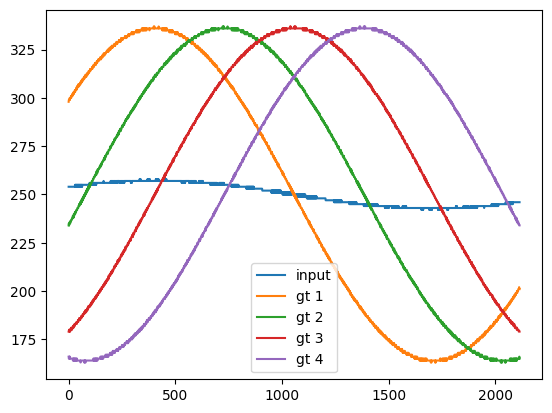

In [2]:
%matplotlib inline

spikes_window = 500
resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.log_out_spikes(-1)
resonator.input_full_data(sine_wave)

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1)

ground_truth = []
# phase_shifts = [22.5, 67.5, 112.5, 157.5]
# phase_shifts = [22.5] + [45]*3
phase_shifts = [0] + [45]*3
phase_shifts = np.cumsum(phase_shifts)
for phase_shift in phase_shifts:
    phase_shift /= 360
    resonator.input_full_data(sine_wave[int((1-phase_shift)*wave_length):int((20-phase_shift)*wave_length)])
    resonator.log_out_spikes(-1)
    resonator.forget_logs()

    resonator.input_full_data(gain*sine_wave[int((1-phase_shift)*wave_length):])
    ground_truth.append(neuron_output(resonator.neurons[0], freq0))

gt1 = ground_truth[0]
gt2 = ground_truth[1]
gt3 = ground_truth[2]
gt4 = ground_truth[3]
rolling_gt = []
plt.plot(rresonator_input, label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')

gt_wave_amplitudes = [(o.max(), o.min()) for o in rolling_gt]

plt.legend()
plt.show()

In [3]:

def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def learning_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    network = simple_resonator(freq0, clk_freq, lf, thetas, weights)
    tau = network.clk_freq * time_to_learn / 2
    network.neurons[1].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    for i in range(3):
        network.neurons[2+i].set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
    return network

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

def argmax(arr):
    return .5 * (np.argmax(arr) + len(arr) - np.argmax(arr[::-1]) - 1)

## Bias + Weights Learning

In [4]:
# chosen_bias=[-1, -5, -5, -5]
# chosen_weights=[11, 9, 10, 10, 10]
plt.rcParams["font.family"] = "Times New Roman"

# chosen_bias=np.array([-15.476, -21.108-2, -18.589, -21.342+1]) - 2
# chosen_weights=np.array([69.227, 38.249, 42.398, 37.236+2, 42.608]) + 4

chosen_weights=np.array([147.352, 103.483, 113.441, 111.941, 114.235]) - 2#np.linspace(0, 4, 5)
chosen_bias=np.array([-21.872, -56.648, -56.075, -57.154]) - 2#np.linspace(0, 2, 4)


In [5]:
resonator = learning_resonator(
    freq0=freq0,
    clk_freq=clk_freq,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
    ground_truths=ground_truth,
    A=2e-4,
    time_to_learn=1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .0

<IPython.core.display.Javascript object>


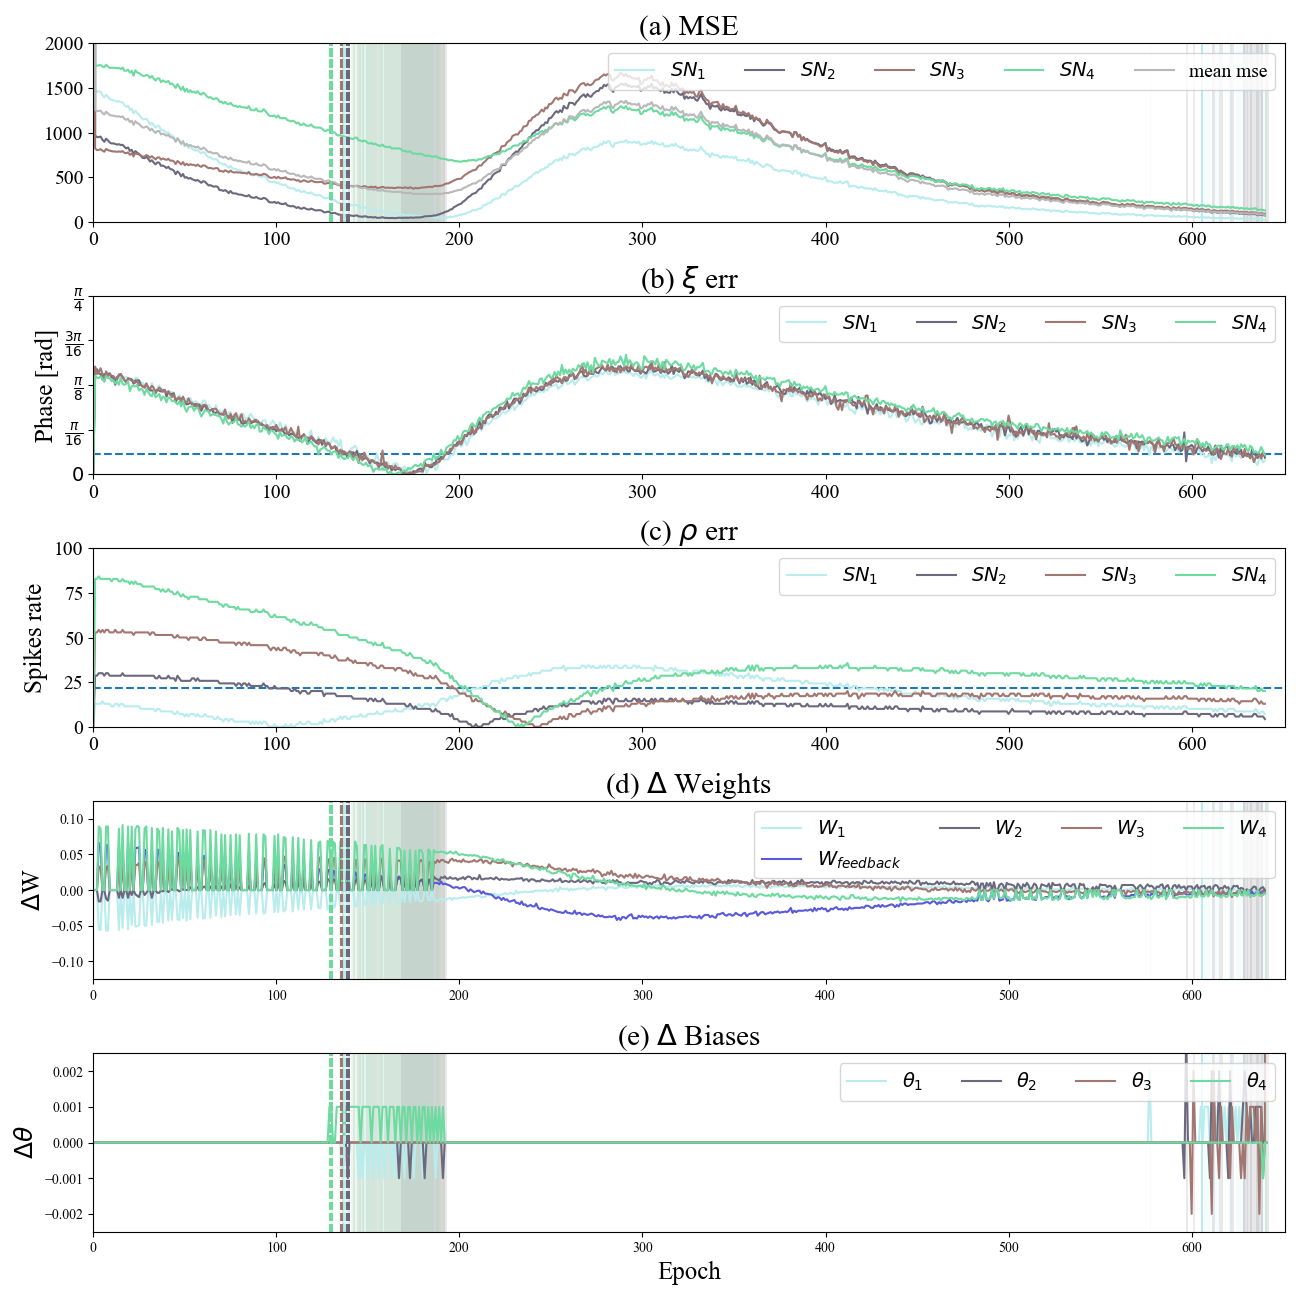

640it [03:44,  1.88it/s, weights=[143.496, 95.87, 116.033, 117.633, 118.573], thetas=[-23.965, -58.765, -58.303, -59.208], mse=73.9, amplitudes=[(342.0, 158.0), (340.0, 151.0), (346.0, 162.0), (350.0, 148.0)], dc=[249.5276595744681, 259.9626477541371, 269.8477541371158, 266.22647754137114], tuned_parameters=6]        

tune
mse [22.658628841607566, 69.94940898345153, 88.69692671394799, 125.49267139479906, 76.69940898345153]


641it [03:45,  2.85it/s, weights=[143.496, 95.87, 116.033, 117.633, 118.573], thetas=[-23.965, -58.765, -58.303, -59.208], mse=73.9, amplitudes=[(342.0, 158.0), (340.0, 151.0), (346.0, 162.0), (350.0, 148.0)], dc=[249.5276595744681, 259.9626477541371, 269.8477541371158, 266.22647754137114], tuned_parameters=6]
C:\Users\User\AppData\Local\Temp\ipykernel_7540\2108769132.py:323: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [22]:
%matplotlib notebook
# im here
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

def_color = '#B8B8B8'
colors = ['#b9eced', '#6c697e', '#a27771', '#6ddaa0']
epochs = 650
title_fontsize = 21
label_fontsize = 18
tick_fontsize = 14


# phase_axs = 0
# mse_axs = 1
# phase_gt_ratio_axs = 2
# amplitude_gt_ratio_axs = 3
# delta_weights_axs = 4
# delta_biases_axs = 5

# heights_ratios = np.ones(6)
# heights_ratios[0] = 2
# fig, axs = plt.subplots(len(heights_ratios), 1, figsize=(13, 16), gridspec_kw={'height_ratios': heights_ratios})
mse_axs = 0
phase_gt_ratio_axs = 1
amplitude_gt_ratio_axs = 2
delta_weights_axs = 3
delta_biases_axs = 4

heights_ratios = np.ones(5)
fig, axs = plt.subplots(len(heights_ratios), 1, figsize=(13, 13), gridspec_kw={'height_ratios': heights_ratios})

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.ones((epochs+1, 5)) * np.inf
mses[0, :4] = np.array([(gt**2).mean() for gt in ground_truth])
mses[0, 4] = mses[0, :4].mean()
min_mse = mses[0, 4]

stdp_amplitude = np.ones((epochs+1, 4)) * np.inf
stdp_amplitude[0, :] = np.array([lr.A for lr in learning_rules])
amplitude_ratio = np.zeros((epochs+1, 4))

stdp_tau = np.ones((epochs+1, 4)) * np.inf
stdp_tau[0, :] = np.array([lr.tau for lr in learning_rules])


phase_ratio = np.zeros((epochs+1, 4))

y_epsilon = spikes_window * 0.03
x_epsilon = len(rresonator_input) * 5 / 360

gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.linspace(0, 360, len(rresonator_input))


# axs[phase_axs].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
# axs[phase_axs].set_xticks([])
# axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.45)
# axs[phase_axs].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.45)

# axs[phase_axs].set_xlabel('Phase [rad]', fontsize=15)
# axs[phase_axs].set_xlabel(' ', fontsize=label_fontsize)
# axs[phase_axs].set_title('(a)', fontsize=title_fontsize)
# axs[phase_axs].set_ylabel('Spikes Rate', fontsize=label_fontsize)
# yticks = np.linspace(150, 350, 6)
# yticks_labels = [0, 100, 200, 300, 400, 500]
# axs[phase_axs].set_yticks(yticks)
# axs[phase_axs].set_yticklabels(yticks_labels, fontsize=tick_fontsize)

# xticks = np.linspace(0, 360, 9)
# xtick_labels = [f'{round(t/180, 2)}' + r'$\pi$' for t in xticks]
# axs[phase_axs].set_xticks(xticks)
# axs[phase_axs].set_xticklabels(xtick_labels, fontsize=tick_fontsize)

# phase_lines = []
# for i in range(4):
#     gt = rolling_gt[i]
#     phase_lines.append(axs[phase_axs].plot(np.linspace(0, 360, len(gt)), gt, label=r'$SN_{i}$'.format(i=i), color=colors[i], linestyle='--', dashes=(1, 5))[0])
#     axs[phase_axs].plot(np.linspace(0, 360, len(gt)), gt, color=colors[i], label=r'$DO_{i}$'.format(i=i), alpha=.8)[0]

norm = 360 / len(rresonator_input)
# [axs[phase_axs].axvspan((peak - x_epsilon)*norm, (peak + x_epsilon)*norm, alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]
# axs[phase_axs].text(16, 327, r'$\updownarrow 2\Delta g$', color='k',fontsize=25)#, weight='bold')
# axs[phase_axs].text(120, 165, r'$2\Delta\xi$', color='k', weight='bold')
# axs[phase_axs].text(117.5, 150, r'$\leftrightarrow$', color='k',fontsize=25)


axs[mse_axs].set_title('(a) MSE', fontsize=title_fontsize)
axs[mse_axs].set_xlim(0, epochs+1)
axs[mse_axs].set_ylim(0, 2000)
axs[mse_axs].tick_params(axis='x', labelsize=tick_fontsize)
axs[mse_axs].tick_params(axis='y', labelsize=tick_fontsize)
mse_lines = [axs[mse_axs].plot([mse], label=r'$SN_{i}$'.format(i=i+1) if i < 4 else 'mean mse', color=color)[0]
             for i, (color, mse) in enumerate(zip(colors + [def_color], mses[0]))]

axs[amplitude_gt_ratio_axs].set_title(r'(c) $\rho$ err', fontsize=title_fontsize)
axs[amplitude_gt_ratio_axs].set_xlim(0, epochs+1)
axs[amplitude_gt_ratio_axs].set_ylabel('Spikes rate', fontsize=label_fontsize)
axs[amplitude_gt_ratio_axs].axhline(y_epsilon * 500/350, 0, 500, linestyle='--')
axs[amplitude_gt_ratio_axs].set_ylim(0, 100)
axs[amplitude_gt_ratio_axs].tick_params(axis='y', labelsize=tick_fontsize)
axs[amplitude_gt_ratio_axs].tick_params(axis='x', labelsize=tick_fontsize)
ampl_ratio_lines = [axs[amplitude_gt_ratio_axs].plot([w], label=r'$SN_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(amplitude_ratio[0])]

axs[phase_gt_ratio_axs].set_title(r'(b) $\xi$ err ', fontsize=title_fontsize)
axs[phase_gt_ratio_axs].set_xlim(0, epochs+1)
axs[phase_gt_ratio_axs].set_ylabel('Phase [rad]', fontsize=label_fontsize)
axs[phase_gt_ratio_axs].axhline(x_epsilon * norm * np.pi / 180, 0, 500, linestyle='--')
axs[phase_gt_ratio_axs].set_ylim(0, np.pi/4)
# yticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
# ytick_labels = [r'$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$', r'$\frac{3\pi}{4}$', r'$\pi$']
yticks = [0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4]
ytick_labels = [r'$0$', r'$\frac{\pi}{16}$', r'$\frac{\pi}{8}$', r'$\frac{3\pi}{16}$', r'$\frac{\pi}{4}$']
axs[phase_gt_ratio_axs].set_yticks(yticks)
axs[phase_gt_ratio_axs].set_yticklabels(ytick_labels, fontsize=tick_fontsize)
axs[phase_gt_ratio_axs].tick_params(axis='x', labelsize=tick_fontsize)
phase_ratio_lines = [axs[phase_gt_ratio_axs].plot([w], label=r'$SN_{i}$'.format(i=i+1), color=colors[i])[0] for i, w in enumerate(phase_ratio[0])]

axs[delta_weights_axs].set_title(r'(d) $\Delta$ Weights ', fontsize=title_fontsize)
axs[delta_weights_axs].set_xlim(0, epochs+1)
axs[delta_weights_axs].set_ylabel(r'$\Delta$W', fontsize=label_fontsize)
axs[delta_weights_axs].set_ylim(-0.125, 0.125)
w_labels = [r'$W_1$', r'$W_{feedback}$', r'$W_2$', r'$W_3$', r'$W_4$']
w_colors = [colors[0]] + ['#5959DA'] + colors[1:]
weights_lines = [axs[delta_weights_axs].plot([w], label=l, color=c)[0] for i, (w, (l , c)) in enumerate(zip(weights[0], zip(w_labels, w_colors)))]

axs[delta_biases_axs].set_title(r'(e) $\Delta$ Biases ', fontsize=title_fontsize)
axs[delta_biases_axs].set_xlim(0, epochs+1)
axs[delta_biases_axs].set_ylabel(r'$\Delta$$\theta$', fontsize=label_fontsize)
axs[delta_biases_axs].set_xlabel('Epoch', fontsize=label_fontsize)
axs[delta_biases_axs].set_ylim(-0.0025, 0.0025)
biases_lines = [axs[delta_biases_axs].plot([b], label=r'$\theta_{i}$'.format(i=i+1), color=colors[i])[0] for i, b in enumerate(biases[0])]



fig.tight_layout()

areas_sns = [[],[],[],[]] 
start_sns = [-1] * 4
momentum = [0] * 4
max_theta = -0.75
tuned_parameters = 0
count_after_tune = -1
with tqdm() as pbar:
    i = 1
    while count_after_tune != 0:
        count_after_tune -= 1
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(sine_wave)

        # mse
        output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
                  for neuron in resonator.neurons[1:]]
        max_y = 0
        mses[i, :4] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
        mses[i, 4] = mses[i, :4].mean()
        if mses[i, 4] < min_mse:
            min_mse = mses[i, 4]
            run_with_stdp = False
        for j, line in enumerate(mse_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(mses[:i, j])
            max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
        for j, sns in enumerate(start_sns):
            if sns != -1:
                axs[mse_axs].axvline(sns, color=colors[j], linestyle='--')
                axs[delta_weights_axs].axvline(sns, color=colors[j], linestyle='--')
                axs[delta_biases_axs].axvline(sns, color=colors[j], linestyle='--')

        # phase chart
#         for j, o in enumerate(output):
#             phase_lines[j].set_ydata(o)

        # stdp charts:
        for j, lr in enumerate(learning_rules):
            stdp_amplitude[i, j] = lr.A
            stdp_tau[i, j] = lr.tau

        thetas_shift = [-.2*(((2*np.mean(o) - spikes_window)/spikes_window)**2)*np.sign(np.mean(o)-spikes_window/2) for o in output]
        for j, neuron in enumerate(resonator.neurons[1:]):
            bs = thetas_shift[j]
            momentum[j] = bs + momentum_beta * momentum[j]
            neuron.theta += momentum[j]
            if neuron.theta > max_theta:
                neuron.theta = max_theta

                
        weights[i, :] = flat_weights(resonator)
        delta_weights = weights[1:, :] - weights[:-1, :]
        biases[i, :] = flat_thetas(resonator)
        delta_biases = biases[1:, :] - biases[:-1, :]
        delta_biases[i-1, :] = 0
        peaks = [argmax(o)for o in output]
        # activate weights learning
        for j, o in enumerate(output):
            dc = o.mean()
            o_max = o.max()
            o_min = o.min()
            neuron = resonator.neurons[1+j]
            # first 2 conditions to check if the amplitude is on the right place.
            # next condition is to check if the peak is in the right place.
            o_argmax = argmax(o)

            if (abs(o_argmax - gt_peaks[j]) <= x_epsilon and
                abs(o_max - gt_wave_amplitudes[j][0]) > y_epsilon/4 and
                abs(o_min - gt_wave_amplitudes[j][1]) > y_epsilon/4
               ):
                if start_sns[j] == -1:
                    start_sns[j] = i
                areas_j = areas_sns[j]
                if areas_j == [] or len(areas_j[-1]) == 2:
                    areas_j.append((i, ))
                stretch_or_shrink_scale = (mses[i, j]*1000//1e4) / 1e4
                if gt_wave_amplitudes[j][1] < o_min < o_max < gt_wave_amplitudes[j][0]:
                    neuron.theta -= stretch_or_shrink_scale
                    neuron.synapses_weights[0] += 2 * stretch_or_shrink_scale
                    if j == 0:
                        neuron.synapses_weights[1] -= 2 * stretch_or_shrink_scale
                elif o_min < gt_wave_amplitudes[j][1] < gt_wave_amplitudes[j][0] < o_max:
                    stretch_or_shrink_scale *= 2
                    neuron.theta += stretch_or_shrink_scale
                    neuron.synapses_weights[0] -= 2 * stretch_or_shrink_scale #/ len(neuron.synapses_weights)
                    if j == 0:
                        neuron.synapses_weights[1] += 2 * stretch_or_shrink_scale  # / len(neuron.synapses_weights)
            else:
                areas_j = areas_sns[j]
                if areas_j != [] and len(areas_j[-1]) == 1:
                    areas_j[-1] = (areas_j[-1][0], i)
                    
            if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
                tuned_parameters += 1
            if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon
            ):
                tuned_parameters += 1

            phase_diff_ratio = abs(peaks[j] - gt_peaks[j])                                   # number between 0 - 1 represent [0 - 180]
            if not run_with_stdp:
                neuron.supervised_stdp = None
                amplitude_ratio[i, j] = amplitude_ratio[i-1, j]
                phase_ratio[i, j] = phase_ratio[i-1, j]
            else:
                wave_amplitude = o_max - o_min
                gt_wave_amplitude = gt_wave_amplitudes[j][0] - gt_wave_amplitudes[j][1]
                wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)        # number between 0 - 1 represent [0 - gt_wave_amplitude]
                neuron.supervised_stdp = learning_rules[j]
                neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 10e-5
                neuron.supervised_stdp.tau = clk_freq / freq0 * (10/180 + abs(peaks[j] - gt_peaks[j]) / len(o))     

            amplitude_ratio[i, j] = abs((o_max - gt_wave_amplitudes[j][0]))
            ampl_ratio_lines[j].set_xdata(np.arange(i))
            ampl_ratio_lines[j].set_ydata(amplitude_ratio[:i, j] * 500/350)

            phase_ratio[i, j] = (phase_diff_ratio * norm * np.pi / 180)%(np.pi)
            phase_ratio_lines[j].set_xdata(np.arange(i))
            phase_ratio_lines[j].set_ydata(phase_ratio[:i, j])
        

        for j, line in enumerate(weights_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(delta_weights[:i, j])
            
        for j, line in enumerate(biases_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(delta_biases[:i, j])

        wave_amplitudes = [(o.max(), o.min()) for o in output]
        pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i, :].mean(),
                          'amplitudes': wave_amplitudes, 'dc': [o.mean() for o in output], 'tuned_parameters': tuned_parameters})

         
        for j in range(len(heights_ratios)):
            axs[j].legend(loc='upper right',  ncol=5 if j == mse_axs else 4, fontsize=14)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i = (i+1) % epochs
        if i == 0:
            i = 1
        
        if tuned_parameters == 8 and count_after_tune < 0:
            count_after_tune = 1
            print('tune')
            print('mse', list(mses[i-1]))


delta_bias_mask = np.zeros_like(delta_biases)
for j, areas in enumerate(areas_sns):
    for area in areas:
        a0 = area[0]
        a1 = i
        if len(area) == 2:
            a1 = area[1]
        alph = .15
        if a0%100 == 5:
            alph = 1
        axs[mse_axs].fill_between(np.arange(a0, a1+1), 0, 2000, facecolor=colors[j], alpha=alph)
        axs[delta_weights_axs].fill_between(np.arange(a0, a1+1), -2000, 2000, facecolor=colors[j], alpha=alph)
        axs[delta_biases_axs].fill_between(np.arange(a0, a1+1), -2000, 2000, facecolor=colors[j], alpha=alph)
        delta_bias_mask[a0-1:a1, j] = 1

delta_biases *= delta_bias_mask

for j, line in enumerate(biases_lines):
    line.set_xdata(np.arange(i))
    line.set_ydata(delta_biases[:i, j])

fig.tight_layout()

In [23]:
fig.savefig('learning_curve.pdf')

In [175]:
min_mse = np.argmin(mses[:i-1].mean(axis=1))
# min_mse = i-1
print(f'min mse {mses[min_mse].mean()}')
chosen_bias = biases[min_mse]
chosen_weights = weights[min_mse]
print(f'chosen_bias={chosen_bias.tolist()}')
print(f'chosen_weights={chosen_weights.tolist()}')

min mse 1201.79621749409
chosen_bias=[-23.884, -58.657, -58.076, -59.146]
chosen_weights=[145.241, 101.611, 111.409, 110.006, 112.41]


In [177]:
# Save just the portion _inside_ the second axis's boundaries
extent = axs[phase_axs].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('phase_axs_a.pdf', bbox_inches=extent.expanded(1.12, 1.28))

In [8]:
flat_weights(resonator).tolist(), flat_thetas(resonator).tolist()

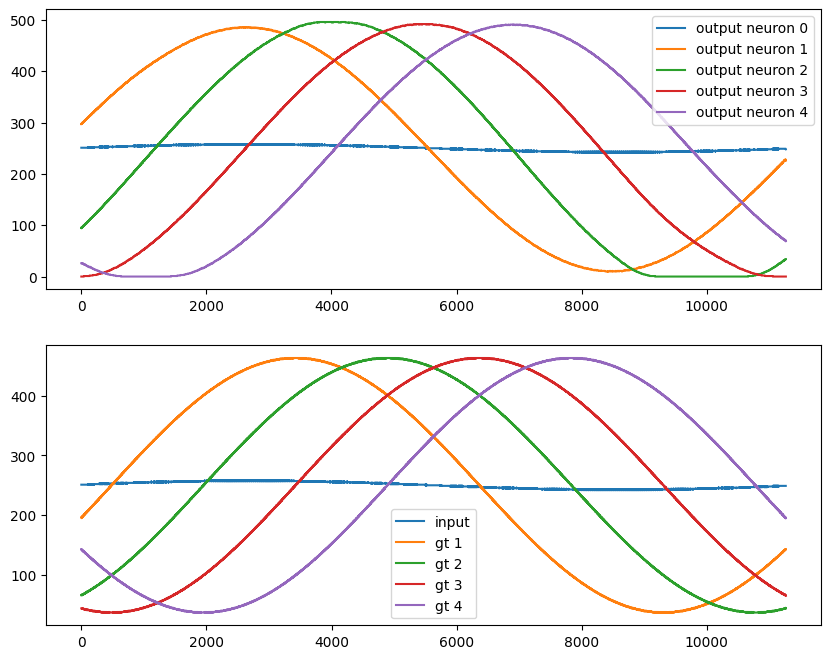

In [49]:
%matplotlib inline
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                           run_window=spikes_window,
                           spikes_arr_size=int(clk_freq/freq0)+3)
          for neuron in res_resonator.neurons]

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, o in enumerate(output):
    axs[0].plot(o, label=f'output neuron {i}')
axs[0].legend()
axs[1].plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    axs[1].plot(gt, label=f'gt {i+1}')

axs[1].legend()

In [56]:
print(chosen_bias, chosen_weights)

[-38.705 -14.082 -11.844 -12.294] [97.872 21.307 27.448 24.055 24.879]


# 250 ~ peak 0.000 nid 1 snr 0.000
# chosen_bias=[-12.937, -23.531, -24.356, -24.554]
# chosen_weights=[70.194, 44.39, 47.087, 48.558, 49.006]
f0 = 249.6526240395885
f0/2 = 301.6803992237533
Q factor 18.713895038416467, f1 = 231.2787472327126, f2 = 249.99264227112906
<class 'numpy.ndarray'>


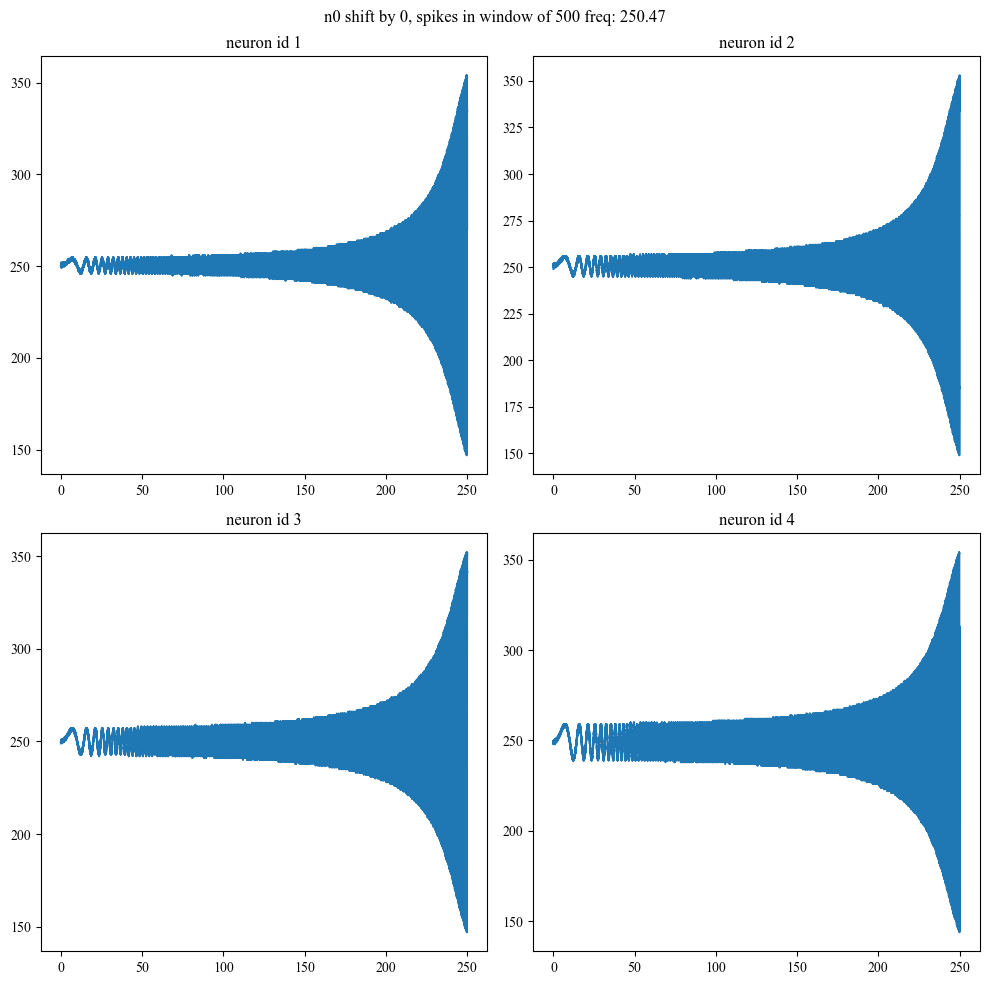

In [6]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
chosen_bias = [
        -12.937,
        -23.531,
        -24.356,
        -24.554
    ]
chosen_weights = [
         70.194,
        44.39,
        47.087,
        48.558,
        49.006
    ]


clk_freq = 1536000
freq0 = 250
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)
spikes_list = []
spikes_array=[]
y_spikes=[]
for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 250
res_resonator.forget_logs()

step = 100/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
fig.tight_layout()



y_spikes_250= y_spikes


nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')
print(type(y_spikes))


# 210 ~ peak 0.000 nid 1 snr 0.000
# chosen_bias=[-12.287, -21.35, -21.922, -21.913]
# chosen_weights=[56.389, 32.463, 42.702, 43.734, 43.7]
f0 = 216.1758041411642
f0/2 = 319.8521240129902
Q factor 23.178669097538744, f1 = 201.7220992316708, f2 = 224.90076832920954


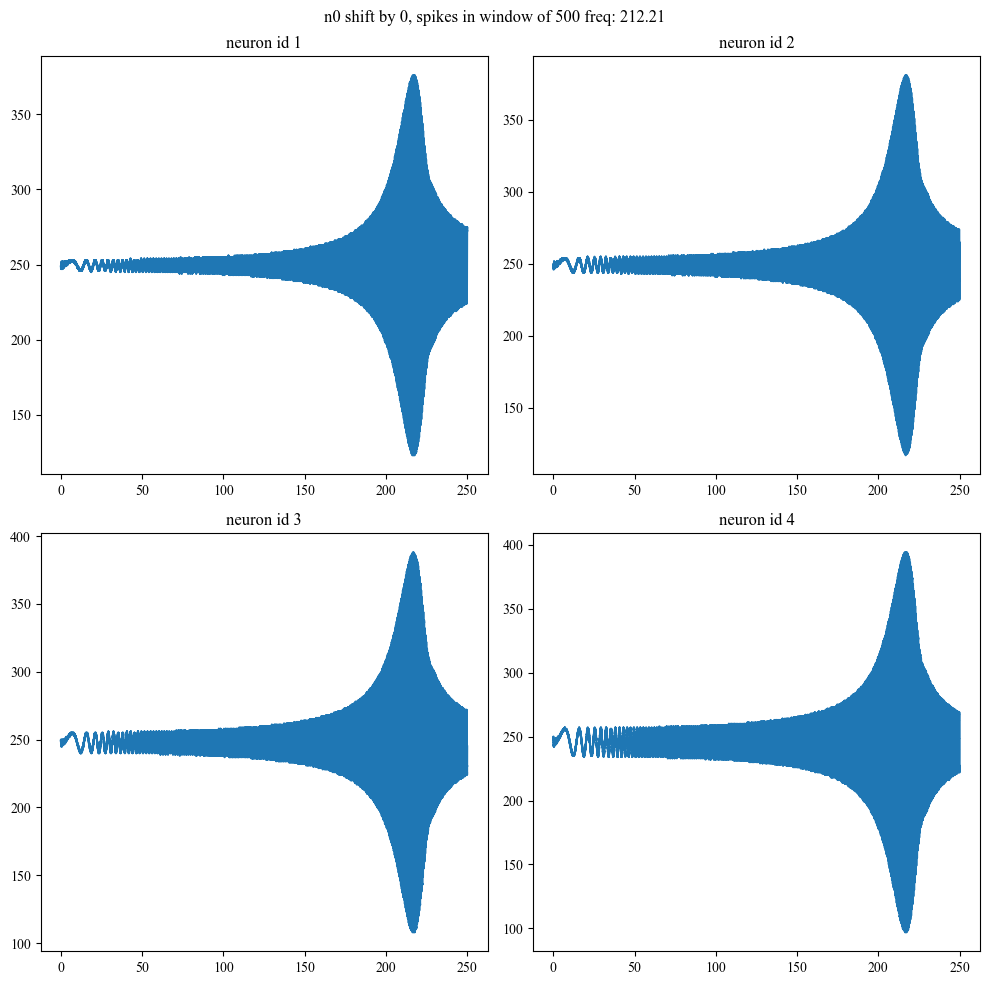

In [7]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

chosen_bias = [
         -12.287,
        -21.35,
        -21.922,
        -21.913
    ]
chosen_weights = [
          56.389,
        32.463,
        42.702,
        43.734,
        43.7
    ]

spikes_list = [] 
clk_freq = 1536000
freq0 = 210
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 250
res_resonator.forget_logs()

step = 100/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
fig.tight_layout()

y_spikes_210= y_spikes





nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

# 170 ~ peak 0.000 nid 1 snr 0.000
# chosen_bias=[-7.992, -16.158, -16.876, -17.57]
# chosen_weights=[44.591, 28.723, 32.551, 33.553, 35.006]
f0 = 174.15998176845943
f0/2 = 301.24281618887454
Q factor 23.582562833702298, f1 = 159.6373876806876, f2 = 183.2199505143899


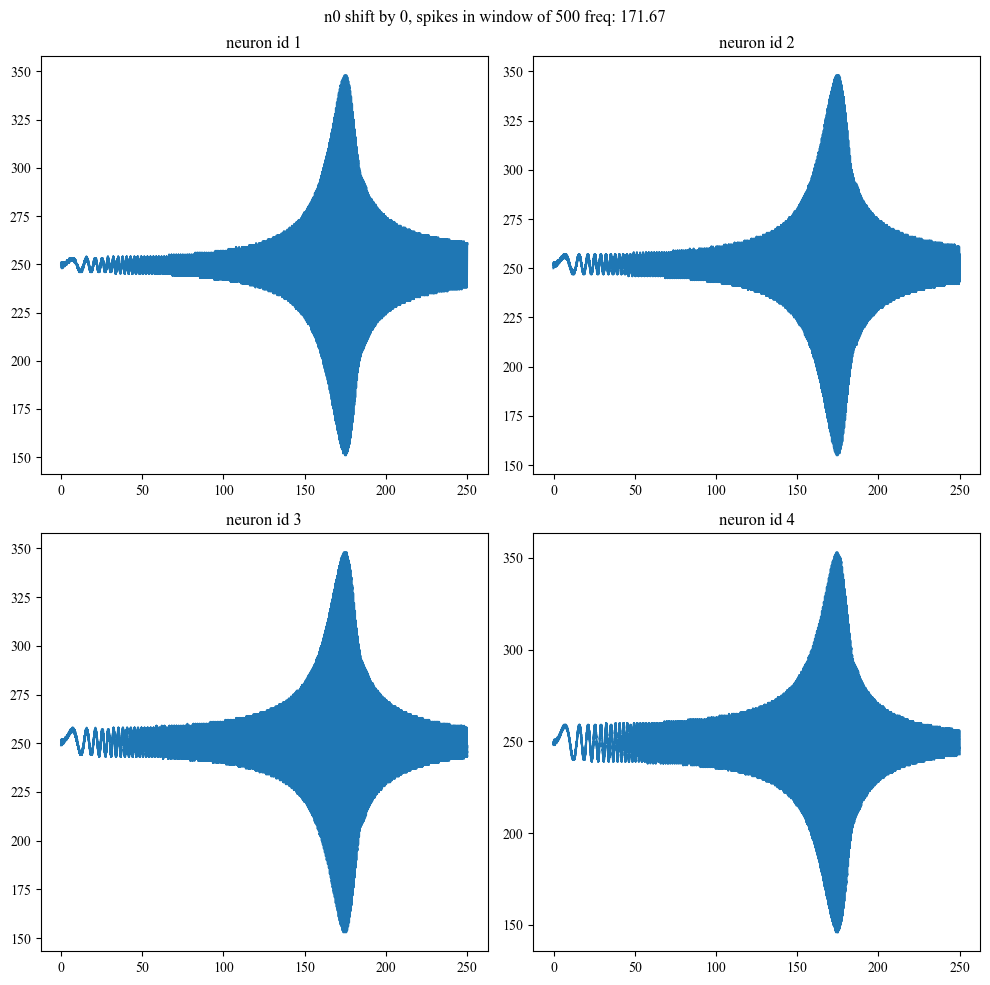

In [8]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

chosen_bias = [
          -7.992,
        -16.158,
        -16.876,
        -17.57
    ]
chosen_weights = [
         44.591,
        28.723,
        32.551,
        33.553,
        35.006
    ]


clk_freq = 1536000
freq0 = 170
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 250
res_resonator.forget_logs()

step = 100/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
fig.tight_layout()


y_spikes_170= y_spikes



nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

# 130 ~ peak 0.000 nid 1 snr 0.000
# chosen_bias=[-5.519, -13.013, -12.731, -12.629]
# chosen_weights=[32.205, 21.629, 26.389, 25.421, 25.393]
f0 = 133.90233103268656
f0/2 = 296.7232099952572
Q factor 19.49166558145592, f1 = 121.17873421018362, f2 = 140.67039979163954


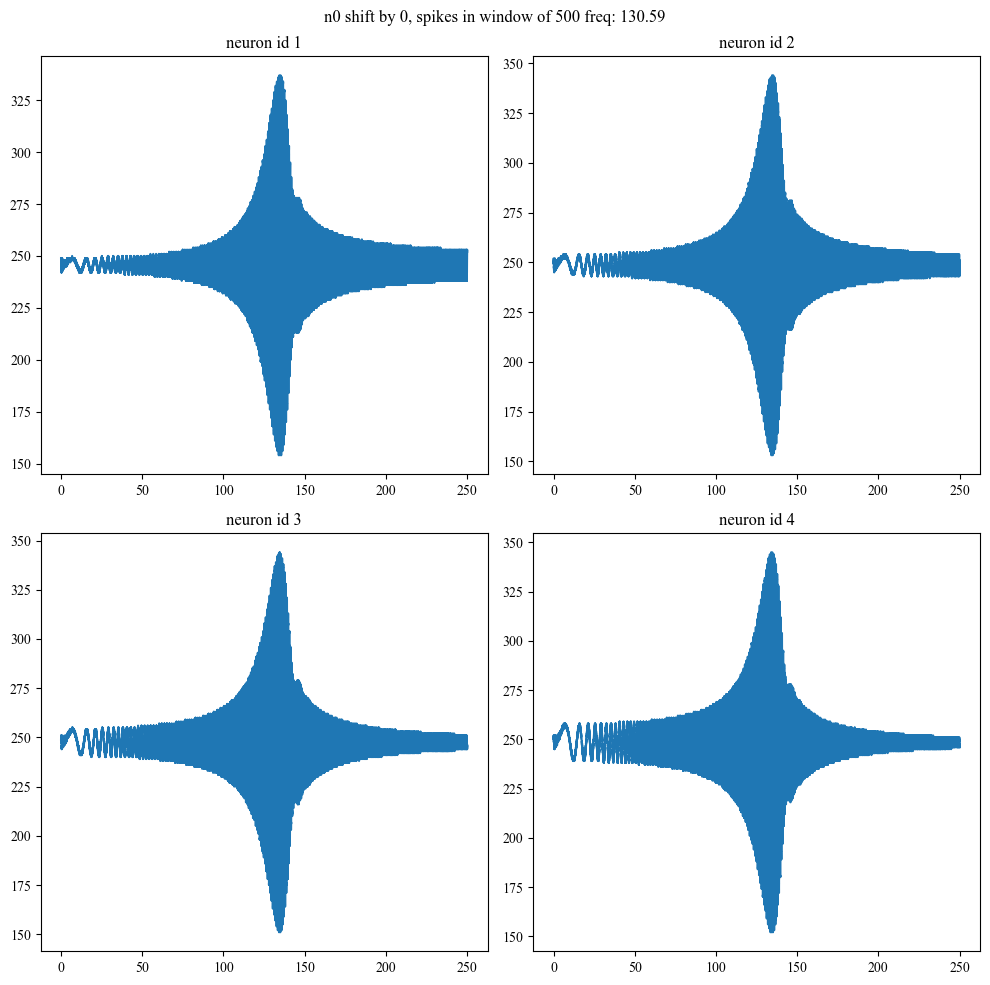

In [9]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

chosen_bias = [
          -5.519,
        -13.013,
        -12.731,
        -12.629
    ]
chosen_weights = [
        32.205,
        21.629,
        26.389,
        25.421,
        25.393
    ]


clk_freq = 1536000
freq0 = 130
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 250
res_resonator.forget_logs()

step = 100/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
fig.tight_layout()



y_spikes_130= y_spikes



nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

# 90 ~ peak 0.000 nid 1 snr 0.000
# chosen_bias=[-2.113, -8.982, -8.803, -8.984]
# chosen_weights=[19.572, 15.247, 17.858, 17.907, 17.915]
f0 = 96.64748014064331
f0/2 = 298.03755514062897
Q factor 14.52519859356687, f1 = 86.5149759083214, f2 = 101.04017450188827


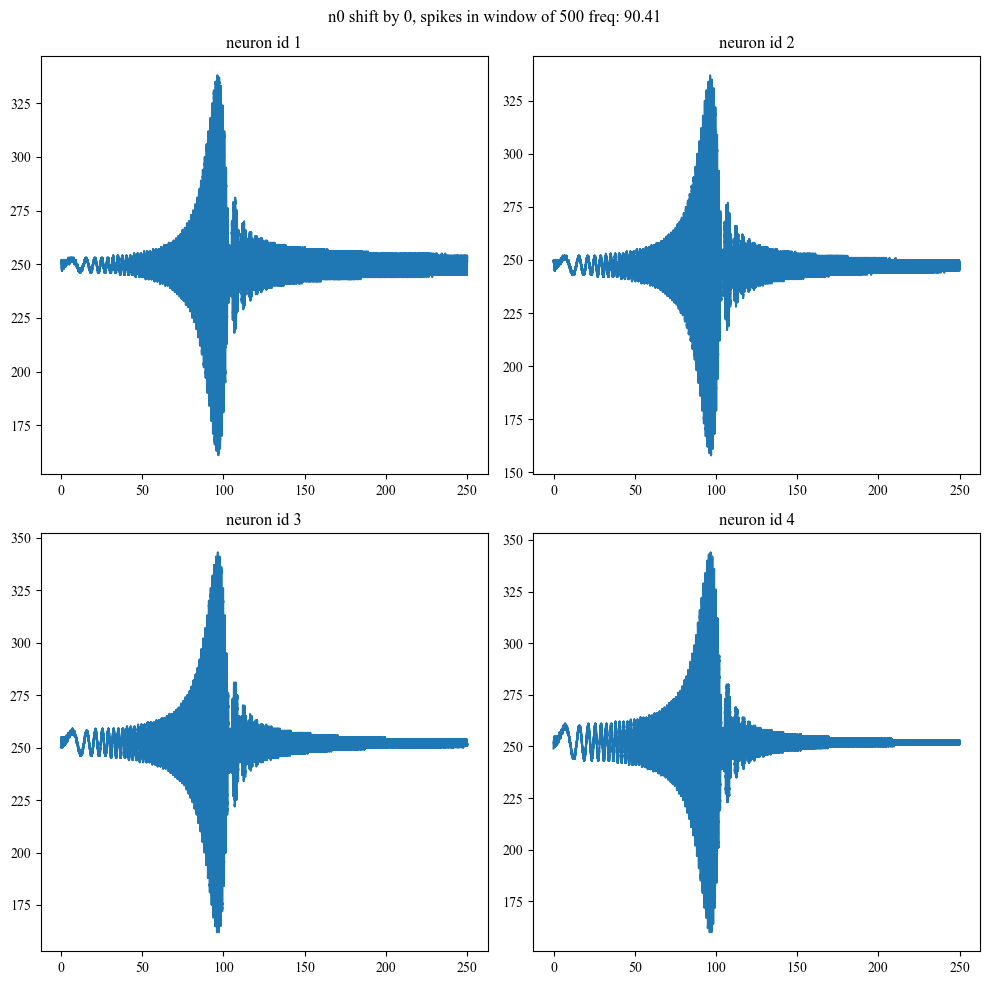

In [10]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

chosen_bias = [
          -2.113,
        -8.982,
        -8.803,
        -8.984
    ]
chosen_weights = [
        19.572,
        15.247,
        17.858,
        17.907,
        17.915
    ]


clk_freq = 1536000
freq0 = 90
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 250
res_resonator.forget_logs()

step = 100/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
fig.tight_layout()


y_spikes_90= y_spikes



nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
# 50 ~ peak 0.000 nid 1 snr 0.000
# chosen_bias=[-0.546, -4.029, -4.439, -5.114]
# chosen_weights=[12.41, 10.444, 8.104, 9.106, 10.255]
f0 = 56.06693579893215
f0/2 = 297.48798828285237
Q factor 12.444589139210834, f1 = 47.7252897512697, f2 = 60.16987889048053


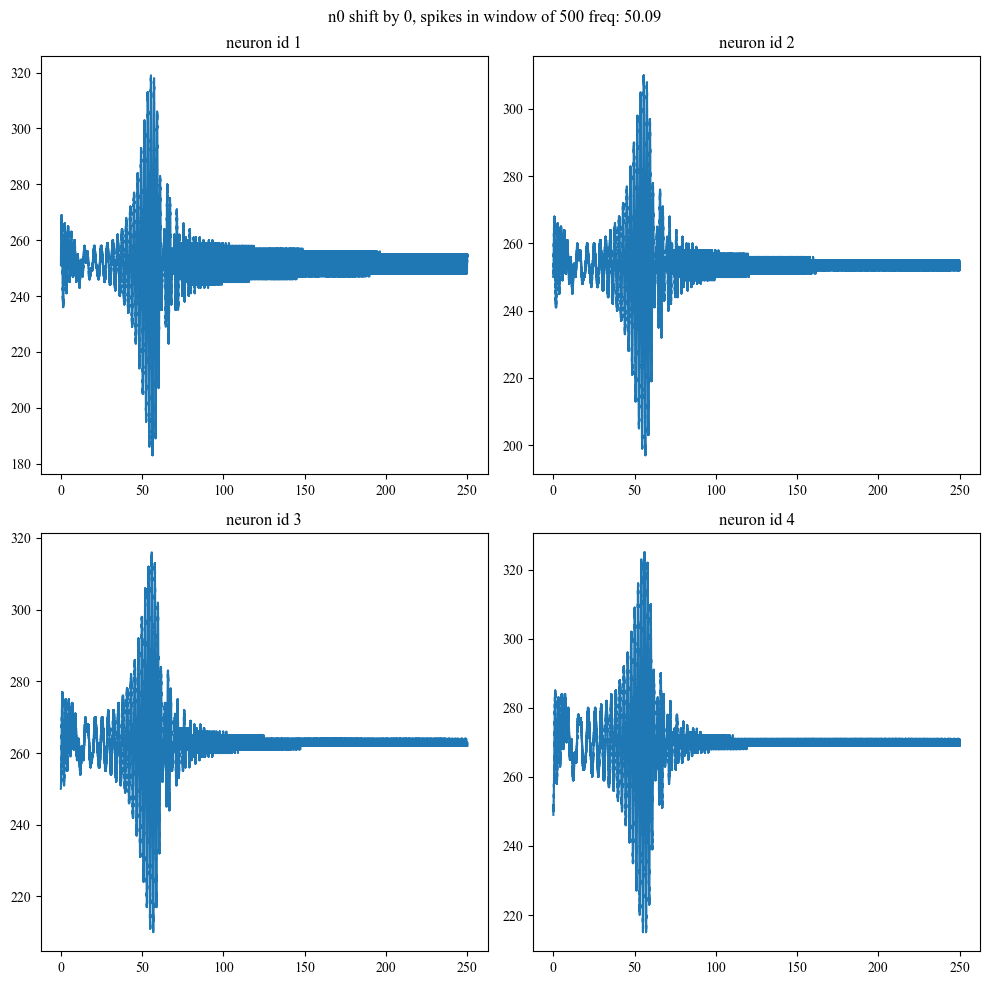

In [11]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator

chosen_bias = [
        -0.546,
        -4.029,
        -4.439,
        -5.114
    ]
chosen_weights = [
         12.41,
        10.444,
        8.104,
        9.106,
        10.255
    ]


clk_freq = 1536000
freq0 = 50
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 250
res_resonator.forget_logs()

step = 100/clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'n0 shift by {phase_shifts[0]}, spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    print(type(y_spikes))
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid + 1}')
fig.tight_layout()


y_spikes_50= y_spikes


nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

f2 = np.mean(y_spikes) + .5*(np.max(y_spikes) - np.mean(y_spikes))
arg_Q = x[(y_spikes > f2*.997) & (y_spikes < f2*1.003)]
print(f'f0 = {x[y_spikes == y_spikes.max()][0]}')
print(f'f0/2 = {f2}')
print(f'Q factor {arg_Q[-1] - arg_Q[0]}, f1 = {arg_Q[0]}, f2 = {arg_Q[-1]}')

In [12]:
list_test=[]

print(len(y_spikes_250),len(y_spikes_210),len(y_spikes_170),len(y_spikes_130),len(y_spikes_90),len(y_spikes_50) )
list_spikes =[y_spikes_250, y_spikes_210,y_spikes_170,y_spikes_130,y_spikes_90,y_spikes_50]
list_spikes

3839501 3839501 3839501 3839501 3839501 3839501


[array([249., 249., 250., ..., 312., 313., 312.]),
 array([249., 249., 250., ..., 226., 226., 227.]),
 array([249., 249., 250., ..., 243., 244., 243.]),
 array([249., 250., 250., ..., 246., 246., 246.]),
 array([249., 250., 250., ..., 252., 251., 252.]),
 array([249., 250., 250., ..., 270., 270., 270.])]

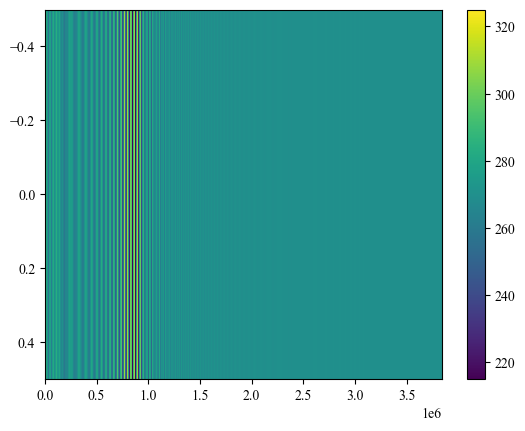

In [19]:
import numpy as np

# Convert the list of arrays to NumPy arrays
list_spikes = [np.array(arr) for arr in list_spikes]

# Find the maximum length of arrays in the list
max_length = max(arr.size for arr in list_spikes)

# Pad arrays with smaller lengths with zeros
for i in range(len(list_spikes)):
    if list_spikes[i].size < max_length:
        padding_length = max_length - list_spikes[i].size
        list_spikes[i] = np.pad(list_spikes[i], (0, padding_length), 'constant', constant_values=(0))


# combined_array = [
#     np.array(list_spikes[0]),
#     np.array(list_spikes[1]),
#     np.array(list_spikes[2]),
#     np.array(list_spikes[3]),
#     np.array(list_spikes[4]),
#     np.array(list_spikes[5])]
combined_array = [np.array(list_spikes[5])]
plt.imshow(combined_array, aspect='auto')
plt.colorbar()
plt.show()

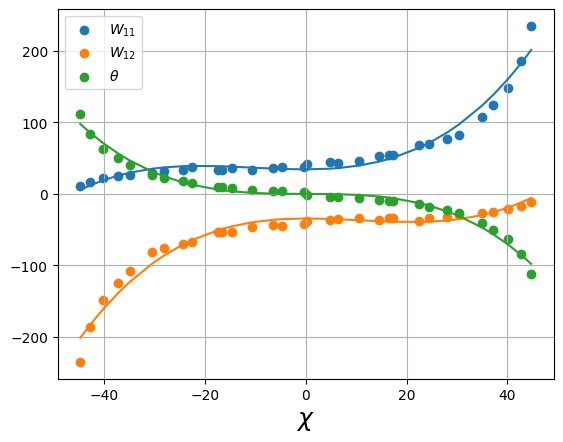

In [21]:
from numpy.polynomial.polynomial import Polynomial
chi_ = np.array([
    44.7, 42.7, 40.2, 37.2, 34.9, 30.4, 28.1, 24.4,
    22.5, 17.3, 16.6, 14.6, 10.6, 6.4, 4.8, 0.3
])[::-1]
bias_ = np.array([
    -112, -84.47, -63.525, -49.822, -40.31, -26.073, -22.22, -18.599,
    -14.785, -9.895, -9.896, -8.455, -6.14, -4.069, -3.714, -2.115,
])[::-1]
w0_ = np.array([
    235, 185.918, 148.636, 124.205, 107.323, 81.819, 76.204, 70.1,
    67.842, 53.799, 53.846, 52.97, 46.254, 43.763, 44.452, 41.551,
])[::-1]
w1_ = np.array([
    10.8, 17.029, 21.698, 24.712, 26.916, 29.788, 31.873, 33.083,
    38.242, 34.073, 34.091,  36.011, 34.107, 35.725, 37.039, 37.349,
])[::-1]

chi = np.concatenate([-chi_[::-1], chi_])
bias = np.concatenate([-bias_[::-1], bias_])
w11 = np.concatenate([w1_[::-1], w0_])
w12 = -np.concatenate([w0_[::-1], w1_])

plt.scatter(chi, w11, label=r'$W_{11}$')
plt.scatter(chi, w12, label=r'$W_{12}$')
plt.scatter(chi, bias, label=r'$\theta$')

deg = 3
w11_fit = Polynomial.fit(chi, w11, deg=deg)
w12_fit = Polynomial.fit(chi, w12, deg=deg)
bias_fit = Polynomial.fit(chi, bias, deg=deg)
plt.plot(chi, w11_fit(chi))
plt.plot(chi, w12_fit(chi))
plt.plot(chi, bias_fit(chi))

plt.grid()
plt.xlabel(r'$\chi$', fontsize=18)
plt.legend()
plt.savefig('chi.pdf')

## Improve DC

In [ ]:
np.argmin(mses.mean(axis=1))

In [36]:
from snn.spiking_neuron import BINARY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
from snn.resonator import trained_resonator

freq0 = 63.6
clk_freq=153600
resonator = trained_resonator(
    freq0=float(freq0),
    filters_folder='filters4_xi0'
)

neuron = create_SCTN()
neuron.synapses_weights = np.array([3.0])
neuron.leakage_period = np.inf
neuron.theta = -1
neuron.threshold_pulse = 3
neuron.reset_to = 1.5
neuron.activation_function = BINARY
resonator.add_layer(SCTNLayer([neuron]))

neuron = create_SCTN()
neuron.synapses_weights = np.array([10.0])
neuron.leakage_period = np.inf
neuron.theta = 0
neuron.leakage_factor = 1
neuron.leakage_period = 1
neuron.threshold_pulse = 30
neuron.reset_to = 10
neuron.activation_function = BINARY
resonator.add_layer(SCTNLayer([neuron]))

In [11]:
from snn.spiking_neuron import BINARY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
from snn.resonator import trained_resonator, delta_resonator

freq0 = 15.9
clk_freq=153600
resonator = delta_resonator(
    freq0=float(freq0),
    filters_folder='filters4_xi0'
)


7.95 6.510416666666667e-06 2442240 153600


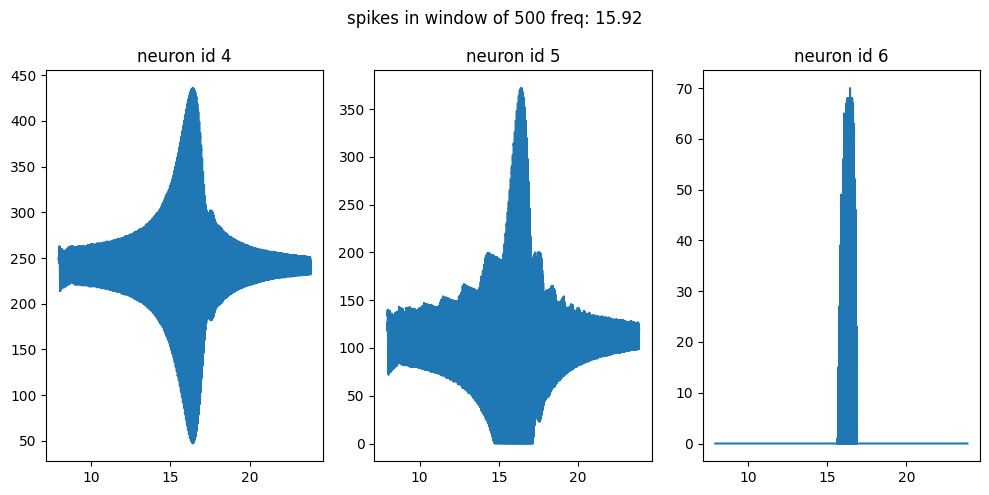

In [12]:
neuronds_id = [4, 5, 6]
for nid in neuronds_id:
    resonator.log_out_spikes(nid)

start_freq = freq0 / 2
spectrum = freq0
resonator.forget_logs()

step = 1/clk_freq
test_size = int(spectrum / step)
print(start_freq, step, test_size, clk_freq)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(1, len(neuronds_id), figsize=(10, 5))
fig.suptitle(f'spikes in window of {spikes_window} freq: {f_resonator:.2f}')
spikes_window = 500
for nid in neuronds_id:
    spikes_neuron = resonator.neurons[nid]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid - neuronds_id[0]]
    ax.plot(x, y_spikes)
    ax.set_title(f'neuron id {nid}')
fig.tight_layout()